# Exercises & Extra-curriculum

## 1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchmetrics import Accuracy

device = "cuda" if torch.cuda.is_available() else "cpu"

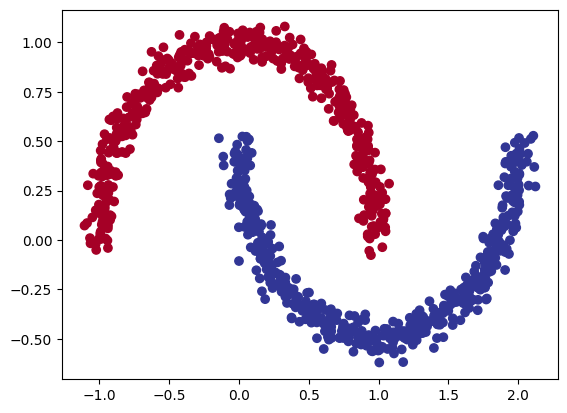

In [ ]:
N_SAMPLES = 1000
RANDOM_SEED = 42

X, y = make_moons(n_samples=N_SAMPLES,
                  noise=0.05,
                  random_state=RANDOM_SEED)

X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.float)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
class ExerciseModelV5(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

model_5 = ExerciseModelV5().to(device)
model_5

ExerciseModelV5(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(),
                             lr=0.01)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
epochs = 200

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_5.train()
    y_logits = model_5(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_5.eval()
    with torch.no_grad():
        test_logits = model_5(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_test.cpu().detach().numpy(), test_pred.cpu().detach().numpy())
    
    if epoch % 10 == 0:
        print(f"Epochs: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epochs: 0 | Loss: 0.7120 | Acc: 0.50% | Test Loss: 0.6989 | Test Acc: 0.50%
Epochs: 10 | Loss: 0.6494 | Acc: 0.83% | Test Loss: 0.6472 | Test Acc: 0.81%
Epochs: 20 | Loss: 0.5474 | Acc: 0.83% | Test Loss: 0.5448 | Test Acc: 0.80%
Epochs: 30 | Loss: 0.4013 | Acc: 0.84% | Test Loss: 0.4036 | Test Acc: 0.80%
Epochs: 40 | Loss: 0.3101 | Acc: 0.85% | Test Loss: 0.3156 | Test Acc: 0.82%
Epochs: 50 | Loss: 0.2649 | Acc: 0.87% | Test Loss: 0.2636 | Test Acc: 0.86%
Epochs: 60 | Loss: 0.2445 | Acc: 0.88% | Test Loss: 0.2406 | Test Acc: 0.90%
Epochs: 70 | Loss: 0.2333 | Acc: 0.89% | Test Loss: 0.2259 | Test Acc: 0.91%
Epochs: 80 | Loss: 0.2248 | Acc: 0.89% | Test Loss: 0.2175 | Test Acc: 0.91%
Epochs: 90 | Loss: 0.2136 | Acc: 0.89% | Test Loss: 0.2050 | Test Acc: 0.91%
Epochs: 100 | Loss: 0.1958 | Acc: 0.91% | Test Loss: 0.1859 | Test Acc: 0.93%
Epochs: 110 | Loss: 0.1730 | Acc: 0.92% | Test Loss: 0.1615 | Test Acc: 0.95%
Epochs: 120 | Loss: 0.1437 | Acc: 0.95% | Test Loss: 0.1318 | Test Acc: 0.9

## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

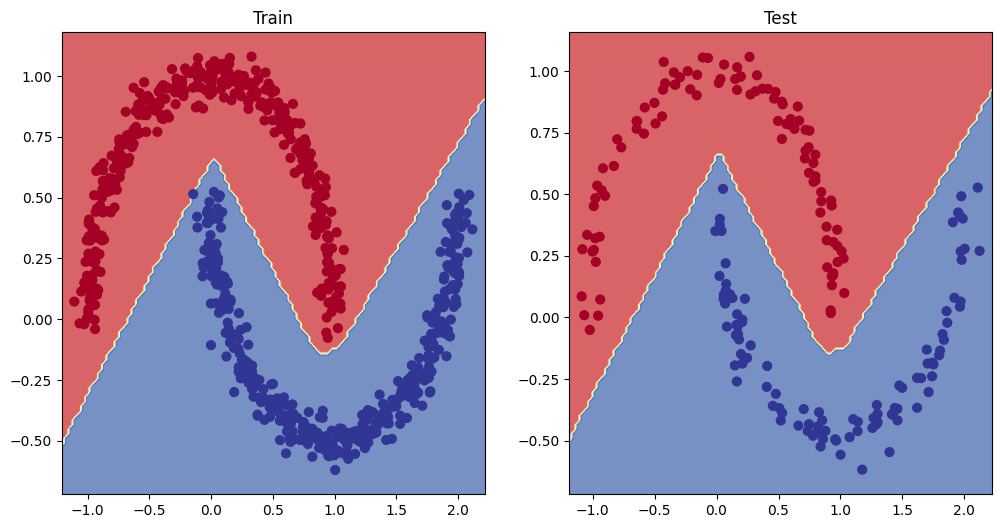

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference the ML cheatsheet website for the formula.

In [ ]:
def tanh(z):
    return (torch.exp(z)-torch.exp(-z))/(torch.exp(z)+torch.exp(-z))

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

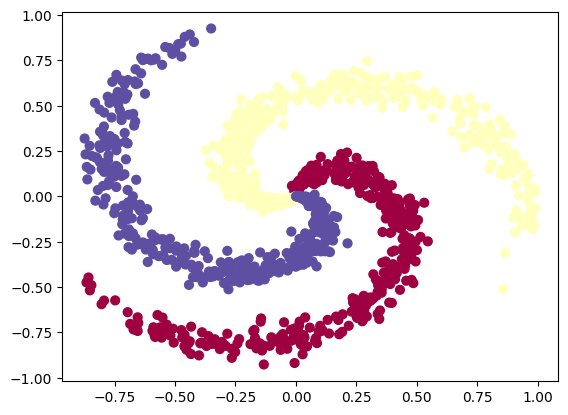

In [ ]:
N = 400 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
X.shape, y.shape

((1200, 2), (1200,))

In [ ]:
X[:10], y[:10], set(y)

(array([[ 0.00000000e+00,  0.00000000e+00],
        [ 2.82079981e-04,  2.49034103e-03],
        [-7.09013369e-05,  5.01202986e-03],
        [-2.10003927e-04,  7.51586366e-03],
        [ 1.84708175e-03,  9.85343444e-03],
        [ 1.52075751e-03,  1.24387092e-02],
        [-2.00335479e-03,  1.49035500e-02],
        [ 1.84452847e-03,  1.74466251e-02],
        [ 4.40851060e-03,  1.95594621e-02],
        [ 8.41045180e-04,  2.25407058e-02]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 {0, 1, 2})

In [ ]:
X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.long)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=RANDOM_SEED)

In [ ]:
class ExerciseModelV6(nn.Module):
    def __init__(self, input_features, output_features, hidden_features):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.Tanh(),
            nn.Linear(in_features=hidden_features, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_tanh_stack(x)

model_6 = ExerciseModelV6(input_features=2,
                          output_features=3,
                          hidden_features=16).to(device)

model_6

ExerciseModelV6(
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_6.parameters(),
                             lr=0.01)

In [ ]:
epochs = 200

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_6.train()
    y_logits = model_6(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_train.cpu().detach().numpy(), y_pred.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_6.eval()
    with torch.inference_mode():
        test_logits = model_6(X_test)
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_pred = torch.argmax(test_pred_probs, dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_test.cpu().detach().numpy(), test_pred.cpu().detach().numpy())

    if epoch % 10 == 0:
        print(f"Epochs: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}")

Epochs: 0 | Loss: 1.1173 | Acc: 0.34 | Test Loss: 1.0844 | Test Acc: 0.32
Epochs: 10 | Loss: 0.8588 | Acc: 0.54 | Test Loss: 0.8487 | Test Acc: 0.53
Epochs: 20 | Loss: 0.7375 | Acc: 0.53 | Test Loss: 0.7750 | Test Acc: 0.54
Epochs: 30 | Loss: 0.7320 | Acc: 0.55 | Test Loss: 0.7773 | Test Acc: 0.54
Epochs: 40 | Loss: 0.7013 | Acc: 0.57 | Test Loss: 0.7377 | Test Acc: 0.55
Epochs: 50 | Loss: 0.6761 | Acc: 0.57 | Test Loss: 0.7081 | Test Acc: 0.56
Epochs: 60 | Loss: 0.6273 | Acc: 0.62 | Test Loss: 0.6616 | Test Acc: 0.59
Epochs: 70 | Loss: 0.5374 | Acc: 0.69 | Test Loss: 0.5684 | Test Acc: 0.67
Epochs: 80 | Loss: 0.4141 | Acc: 0.82 | Test Loss: 0.4436 | Test Acc: 0.80
Epochs: 90 | Loss: 0.2984 | Acc: 0.91 | Test Loss: 0.3354 | Test Acc: 0.89
Epochs: 100 | Loss: 0.2208 | Acc: 0.95 | Test Loss: 0.2719 | Test Acc: 0.93
Epochs: 110 | Loss: 0.1741 | Acc: 0.97 | Test Loss: 0.2282 | Test Acc: 0.95
Epochs: 120 | Loss: 0.1435 | Acc: 0.97 | Test Loss: 0.1926 | Test Acc: 0.95
Epochs: 130 | Loss: 0.1

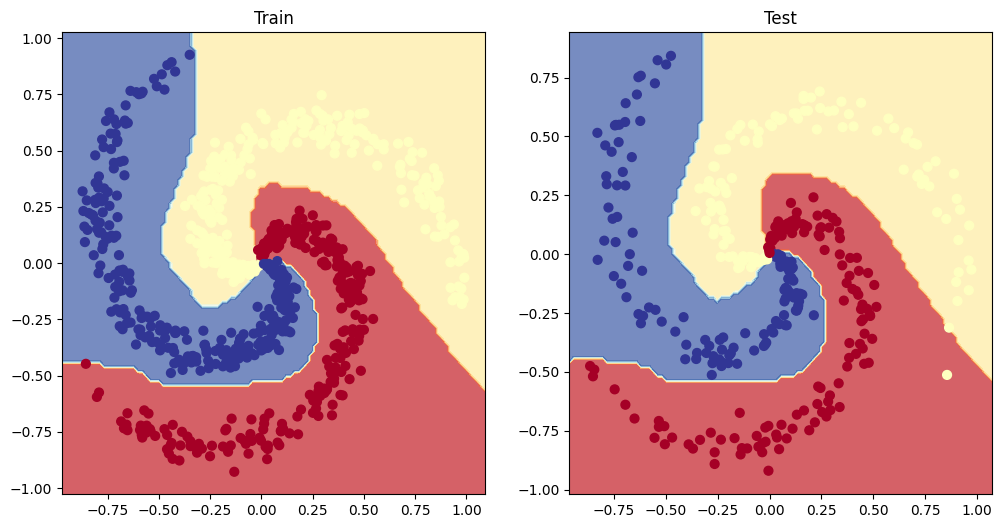

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_6, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_6, X_test, y_test)